<a href="https://colab.research.google.com/github/Rs-Biranchi/Fake-News-Detection-Project/blob/main/Fake_ews_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_news.csv')
data

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1
...,...,...,...,...,...,...
20795,20795,5671,NaN,NeverSurrender,"No, you'll be a dog licking of the vomit of yo...",1
20796,20796,14831,Albert Pike and the European Migrant Crisis,Rixon Stewart,"By Rixon Stewart on November 5, 2016 Rixon Ste...",1
20797,20797,18142,Dakota Access Caught Infiltrating Protests to ...,Eddy Lavine,posted by Eddie You know the Dakota Access Pip...,1
20798,20798,12139,How to Stretch the Summer Solstice - The New Y...,Alison S. Cohn,"It’s officially summer, and the Society Boutiq...",0


In [3]:
print('Shape of the dataset: ',data.shape)

Shape of the dataset:  (20800, 6)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20800 non-null  int64 
 1   id          20800 non-null  int64 
 2   headline    20242 non-null  object
 3   written_by  18843 non-null  object
 4   news        20761 non-null  object
 5   label       20800 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 975.1+ KB


There are many nan values are present in the headline,written_by & in news features .Let's see what are featurewise null values.

In [5]:
null=data.isna().sum()
print(null)

Unnamed: 0       0
id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64


In [6]:
data.describe()

,Unnamed: 0,id,label
count,20800.000000,20800.000000,20800.000000
mean,10399.500000,10399.500000,0.500625
std,6004.587135,6004.587135,0.500012
min,0.000000,0.000000,0.000000
25%,5199.750000,5199.750000,0.000000
50%,10399.500000,10399.500000,1.000000
75%,15599.250000,15599.250000,1.000000
max,20799.000000,20799.000000,1.000000


In [7]:
data.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

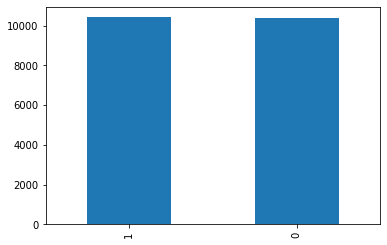

In [8]:
data.label.value_counts().plot.bar()

About 50% of news are Fake and rest are True.

In [9]:
#Chcking if there any duplicate rows and dropping them
data1=data.drop_duplicates()
data1.shape

(20800, 6)

In [10]:
#On the model Unnamed: 0 and id columns have no effect. So We can drop the columns.
data.drop(['Unnamed: 0','id'],axis=1,inplace=True)
data.head()

,headline,written_by,news,label
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [11]:
#written_by
data.written_by.value_counts

<bound method IndexOpsMixin.value_counts of 0        Eric Lipton and Steve Eder
1                   David Waldstein
2                           Pam Key
3                      Jess Bidgood
4                 Finian Cunningham
                    ...            
20795                NeverSurrender
20796                 Rixon Stewart
20797                   Eddy Lavine
20798                Alison S. Cohn
20799                  Tom Ciccotta
Name: written_by, Length: 20800, dtype: object>

In [12]:
len(data.written_by.unique())

4202

The number of Authors are 4202.

In [13]:
#Replacing all the null values with space.
data.headline.replace(np.nan," ",inplace=True)
data.news.replace(np.nan," ",inplace=True)
data.isna().sum()

headline         0
written_by    1957
news             0
label            0
dtype: int64

As headline also describes about the news and most of the time it is also responsible if the news is fake or not. So we join both the features before feeding the data into the trainig model.

In [14]:
data['all_news']=data['news']+" "+data['headline']
data.head()

,headline,written_by,news,label,all_news
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,"WASHINGTON — In Sonny Perdue’s telling, Geo..."
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,HOUSTON — Venezuela had a plan. It was a ta...
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,"Sunday on ABC’s “This Week,” while discussing ..."
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,"AUGUSTA, Me. — The beleaguered Republican g..."
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,Finian Cunningham has written extensively on...


In [15]:
data['h_len']=data.headline.str.len()
data['n_len']=data.news.str.len()
data['all_news_len']=data.all_news.str.len()
data.head()

,headline,written_by,news,label,all_news,h_len,n_len,all_news_len
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",84,7936,8021
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0,HOUSTON — Venezuela had a plan. It was a ta...,72,6112,6185
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0,"Sunday on ABC’s “This Week,” while discussing ...",100,425,526
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0,"AUGUSTA, Me. — The beleaguered Republican g...",100,6516,6617
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1,Finian Cunningham has written extensively on...,28,9164,9193


In [16]:
#Now we can drop headline and news columns as we joined both the features into a single feature all_news
data.drop(['headline','news'],axis=1,inplace=True)
data.head()

,written_by,label,all_news,h_len,n_len,all_news_len
0,Eric Lipton and Steve Eder,0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",84,7936,8021
1,David Waldstein,0,HOUSTON — Venezuela had a plan. It was a ta...,72,6112,6185
2,Pam Key,0,"Sunday on ABC’s “This Week,” while discussing ...",100,425,526
3,Jess Bidgood,0,"AUGUSTA, Me. — The beleaguered Republican g...",100,6516,6617
4,Finian Cunningham,1,Finian Cunningham has written extensively on...,28,9164,9193


In [17]:
#We train the model on all_news feature so converting it to Lowercase
data['all_news']=data['all_news'].str.lower()
data.head()

,written_by,label,all_news,h_len,n_len,all_news_len
0,Eric Lipton and Steve Eder,0,"washington — in sonny perdue’s telling, geo...",84,7936,8021
1,David Waldstein,0,houston — venezuela had a plan. it was a ta...,72,6112,6185
2,Pam Key,0,"sunday on abc’s “this week,” while discussing ...",100,425,526
3,Jess Bidgood,0,"augusta, me. — the beleaguered republican g...",100,6516,6617
4,Finian Cunningham,1,finian cunningham has written extensively on...,28,9164,9193


In [18]:
stopwords=stopwords.words('english')
#removing stopwords
data.all_news=data.all_news.apply(lambda x: ' '.join(
    word for word in x.split() if word not in stopwords
))

In [19]:
#Removing punctuations
data.all_news=data.all_news.str.replace(r'[^\w\d\s]'," ")

#Removing more than one leading and trailing spaces
data.all_news=data.all_news.str.replace(r'^s+|s+?$', " ")

#Replacing Leading and trauiling tabs with space
data.all_news=data.all_news.str.replace(r'^t+|t+?$'," ")

#Creating feature clean_all_news_length
data['cleaned_all_news_len']=data.all_news.str.len()

data.head()

,written_by,label,all_news,h_len,n_len,all_news_len,cleaned_all_news_len
0,Eric Lipton and Steve Eder,0,washington sonny perdue s telling georgians...,84,7936,8021,5915
1,David Waldstein,0,houston venezuela plan tactical approach d...,72,6112,6185,4536
2,Pam Key,0,unday abc s this week discussing republica...,100,425,526,381
3,Jess Bidgood,0,augusta me beleaguered republican governor...,100,6516,6617,4877
4,Finian Cunningham,1,finian cunningham written extensively internat...,28,9164,9193,6986


In [20]:
#The data is cleaned.we vectorize the data by TfidfVectorizer and split the dependent and independent sets
tfidf=TfidfVectorizer()

x=tfidf.fit_transform(data.all_news)

y=data.label

In [21]:
#Checking for best randomstate
max_acc_scr=0
for r_state in range(42,101):
  train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=r_state,test_size=0.25)
  mnb=MultinomialNB()
  mnb.fit(train_x,train_y)
  pred=mnb.predict(test_x)
  acc_scr=accuracy_score(pred,test_y)
  if acc_scr>max_acc_scr:
    max_acc_scr=acc_scr
    final_r_state=r_state
  print("Max Accuracy score corresponding to ",final_r_state," is ",max_acc_scr)

Max Accuracy score corresponding to  42  is  0.8611538461538462
Max Accuracy score corresponding to  42  is  0.8611538461538462
Max Accuracy score corresponding to  42  is  0.8611538461538462
Max Accuracy score corresponding to  45  is  0.8646153846153846
Max Accuracy score corresponding to  45  is  0.8646153846153846
Max Accuracy score corresponding to  47  is  0.8653846153846154
Max Accuracy score corresponding to  47  is  0.8653846153846154
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.874423076923077
Max Accuracy score corresponding to  49  is  0.8

In [22]:
#At random_state 49 the accuracy is highest. So we take random_state 49 for fianl splitting
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=49,test_size=0.25,shuffle=True,stratify=y)

In [23]:
model=[MultinomialNB(),LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier()]
for m in model:
  m.fit(train_x,train_y)
  predm=m.predict(test_x)
  print("Model",m)
  print("Accruracy Score",accuracy_score(predm,test_y))
  print("Confusion Matrix: \n",confusion_matrix(predm,test_y))
  print("Classification report:\n",classification_report(test_y,predm))
  print("*"*70)

Model MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accruracy Score 0.8536538461538462
Confusion Matrix: 
 [[2565  729]
 [  32 1874]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87      2597
           1       0.98      0.72      0.83      2603

    accuracy                           0.85      5200
   macro avg       0.88      0.85      0.85      5200
weighted avg       0.88      0.85      0.85      5200

**********************************************************************
Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accruracy Score 0.9532692307692308
Confusion Matrix: 
 [[2438   84]
 [ 159 2519]]
Classification re

In [24]:
from sklearn.ensemble import RandomForestClassifier

#Checking the score by RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(train_x,train_y)
rfpred=rf.predict(test_x)
print("Accruracy Score",accuracy_score(predm,test_y))
print("Confusion Matrix: \n",confusion_matrix(predm,test_y))
print("Classification report:\n",classification_report(test_y,predm))

Accruracy Score 0.8221153846153846
Confusion Matrix: 
 [[1829  157]
 [ 768 2446]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80      2597
           1       0.76      0.94      0.84      2603

    accuracy                           0.82      5200
   macro avg       0.84      0.82      0.82      5200
weighted avg       0.84      0.82      0.82      5200



Among all the classifiers LogisticRegression has the highest F1score,Accuracy,recall and precision among all the Classifiers.So we finalize LogisticRegression as Final Model.

In [26]:
Lr=LogisticRegression()
param={'penalty':['l1','l2','elasticnet','none'],'class_weight':['dict','balanced'],'solver':['newton-cg','lbfgs','liblinear']}
gd_sr=GridSearchCV(estimator=Lr,param_grid=param,cv=5,scoring='f1')
gd_sr.fit(train_x,train_y)
best_param=gd_sr.best_params_
print(best_param)
best_score=gd_sr.best_score_
print(best_score)

{'class_weight': 'dict', 'penalty': 'none', 'solver': 'newton-cg'}
0.969263039760239


In [29]:
#Final model
lr=LogisticRegression(penalty='none',solver='newton-cg',class_weight='balanced')
lr.fit(train_x,train_y)
lrpred=lr.predict(test_x)
print("Accruracy Score",accuracy_score(lrpred,test_y))
print("Confusion Matrix: \n",confusion_matrix(lrpred,test_y))
print("Classification report:\n",classification_report(lrpred,test_y))

Accruracy Score 0.9665384615384616
Confusion Matrix: 
 [[2490   67]
 [ 107 2536]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2557
           1       0.97      0.96      0.97      2643

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



In [30]:
#Checking if the model is over or underfitted
c_score=cross_val_score(lr,x,y,scoring='f1',cv=5)
print(c_score)
print(np.mean(c_score))

[0.97367161 0.97026379 0.97100407 0.97288217 0.97145576]
0.9718554803675202


In [31]:
a_score=cross_val_score(lr,x,y,scoring='accuracy',cv=5)
print(a_score)
print(np.mean(a_score))

[0.97355769 0.97019231 0.97091346 0.97283654 0.97115385]
0.9717307692307692


In [33]:
#Model is well fitted.

In [36]:
print('The prediction are: ',lrpred)

The prediction are:  [1 1 0 ... 1 1 1]


In [37]:
#Saving the prediction in a csv file
df=pd.DataFrame(lrpred)
df.to_csv("news_prediction.csv")

#saving the model for production
from sklearn.externals import joblib
joblib.dump(lr,"news_prediction_model.obj")

['news_prediction_model.obj']